In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from segmentation.fuzzy_c_means import FuzzyCMeansSegmenter
import os

In [2]:
folder_path = "/workspaces/python-opencv/resources/VisDrone2019-SOT-train/sequences/uav0000169_00000_s/"
out_path = "/workspaces/python-opencv/repo/out/my_stuff.mp4"

In [3]:
pictures = sorted(os.listdir(folder_path))
fps = 30

In [4]:
frame0 = cv.imread(folder_path + pictures[0])
frame1 = cv.imread(folder_path + pictures[1])

In [5]:
x, y, w, h = 610, 410, 60, 65
track_window = (x, y, w, h)

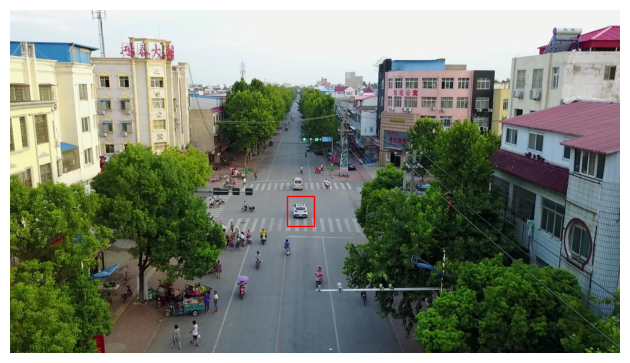

In [6]:
fig, ax = plt.subplots()
plt.imshow(frame1[:, :, ::-1])
rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.axis("off")
plt.tight_layout()
plt.show()

## color histogram

In [7]:
roi = frame1[y:y+h, x:x+w, :]

histogram_region = roi
histogram_region_hsv = cv.cvtColor(histogram_region, cv.COLOR_BGR2HSV) 

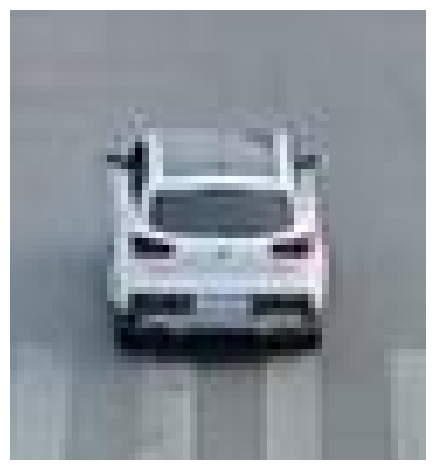

In [8]:
plt.imshow(roi[:, :, ::-1])
plt.axis("off")
plt.tight_layout()
plt.show()

In [9]:
fuzzy = FuzzyCMeansSegmenter(5, 0, 5, 2, 2, 100)
segmented, centroids = fuzzy.segment_image(histogram_region_hsv, return_centroid=True)

subset_segmented = segmented[int(h/4):int(3 * h/4), int(w/4):int(3 * w/4)]
# subset_segmented = segmented

counts = np.bincount(subset_segmented.flatten())
dominant_index = np.argmax(counts)
dominant_color = centroids[dominant_index]

In [10]:
dominant_color

array([106.07634907,  37.17932154, 174.73676179])

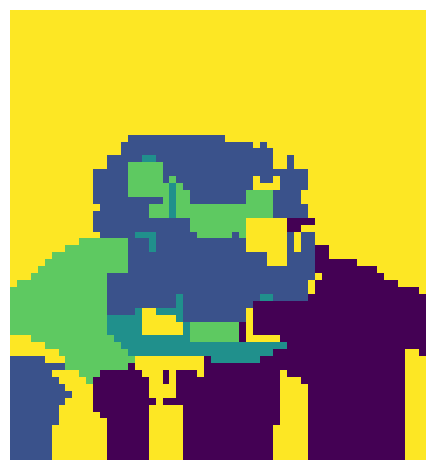

In [11]:
plt.imshow(segmented)
plt.axis("off")
plt.tight_layout()
plt.show()

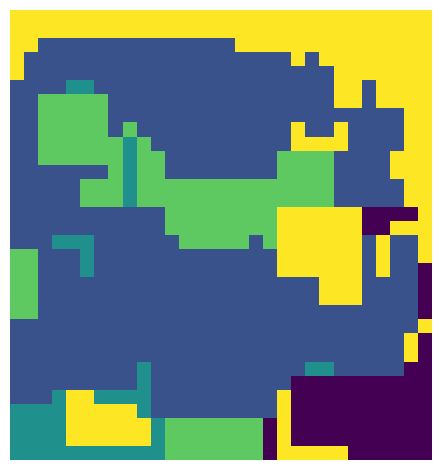

In [12]:
plt.imshow(subset_segmented)
plt.axis("off")
plt.tight_layout()
plt.show()

In [13]:
_h, _s, _v = dominant_color
std_h, std_s, std_v = np.std(histogram_region_hsv, axis=(0, 1))

lower_bound = np.array([max(_h - std_h, 0), max(_s - std_s, 0), max(_v - std_v, 0)])
upper_bound = np.array([min(_h + std_h, 180), min(_s + std_s, 255), min(_v + std_v, 255)])

print(lower_bound)
print(upper_bound)

[ 99.49553655   9.59749718 138.05567759]
[112.65716159  64.76114589 211.41784599]


In [14]:
img_hsv_roi = cv.cvtColor(roi, cv.COLOR_BGR2HSV)
img_mask = cv.inRange(img_hsv_roi, lower_bound, upper_bound)

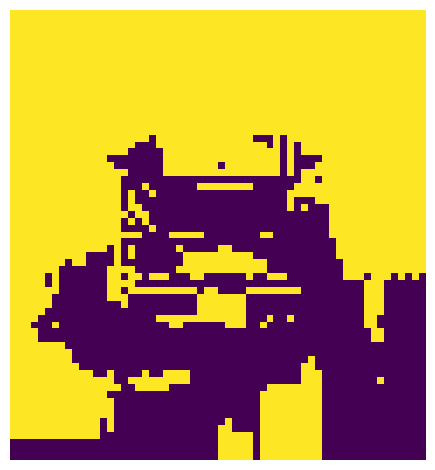

In [15]:
plt.imshow(img_mask)
plt.axis("off")
plt.tight_layout()
plt.show()

## motion histogram

### getting hsv image from motion

In [16]:
def to_hsv(out_mat, flow):
    mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])
    out_mat[..., 0] = ang * 90/np.pi
    out_mat[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)

In [17]:
hsv_flow = np.zeros_like(frame1)
hsv_flow[..., 1] = 255

In [18]:
frame0_gray = cv.cvtColor(frame0, cv.COLOR_BGR2GRAY)
frame1_gray = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)

In [19]:
flow = cv.calcOpticalFlowFarneback(frame0_gray, frame1_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

In [20]:
to_hsv(hsv_flow, flow)

### computing hist values

In [21]:
x, y, w, h

(610, 410, 60, 65)

In [22]:
flow_hsv_roi = hsv_flow[y:y+h, x:x+w, :]

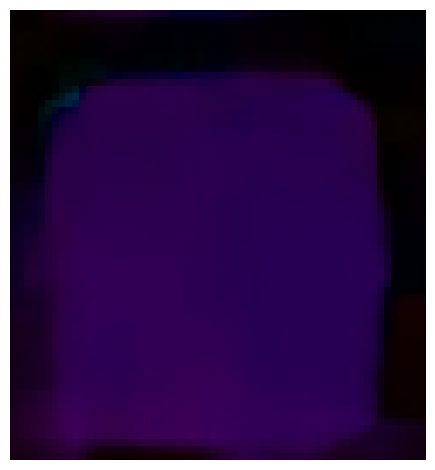

In [23]:
temp = cv.cvtColor(flow_hsv_roi, cv.COLOR_HSV2BGR)

plt.imshow(temp[:, :, ::-1])
plt.axis("off")
plt.tight_layout()
plt.show()

In [24]:
fuzzy = FuzzyCMeansSegmenter(5, 0, 5, 2, 2, 100)
segmented, centroids = fuzzy.segment_image(flow_hsv_roi, return_centroid=True)

subset_segmented = segmented[int(h/4):int(3 * h/4), int(w/4):int(3 * w/4)]
# subset_segmented = segmented

counts = np.bincount(subset_segmented.flatten())
dominant_index = np.argmax(counts)
dominant_color = centroids[dominant_index]
print(dominant_color)

[136.40874182 255.          75.54329656]


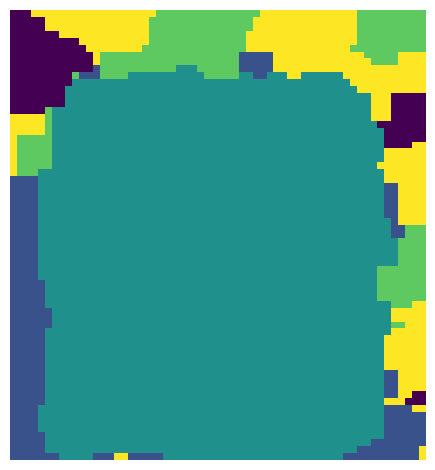

In [25]:
plt.imshow(segmented)
plt.axis("off")
plt.tight_layout()
plt.show()

In [26]:
_h, _s, _v = dominant_color
std_h, std_s, std_v = np.std(flow_hsv_roi, axis=(0, 1))

std_s = 5

lower_bound = np.array([max(_h - std_h, 0), max(_s - std_s, 0), max(_v - std_v, 0)])
upper_bound = np.array([min(_h + std_h, 180), min(_s + std_s, 255), min(_v + std_v, 255)])

print(lower_bound)
print(upper_bound)

[109.57136074 250.          44.28260986]
[163.2461229  255.         106.80398327]


In [27]:
flow_mask = cv.inRange(flow_hsv_roi, lower_bound, upper_bound)

## combined histogram

In [28]:
feed_into_hist = np.concatenate((img_hsv_roi, flow_hsv_roi), axis = -1)
mask_into_hist = np.where(np.logical_and((img_mask == 0), (flow_mask == 0)), 0, 255).astype(np.uint8)

In [29]:
roi_hist = cv.calcHist([feed_into_hist], [0], mask_into_hist, [180], [0, 180])
roi_hist = cv.normalize(roi_hist, roi_hist, 0, 255, cv.NORM_MINMAX)

## rest

In [30]:
fourcc = cv.VideoWriter_fourcc(*'mp4v')
video_out = cv.VideoWriter(out_path, fourcc, fps, frame1.shape[0:2][::-1]) 

In [31]:
term_crit = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1)

In [32]:
# Optical flow stuff
hsv_flow = np.zeros_like(frame1)
hsv_flow[..., 1] = 255

In [33]:
frame_like = np.zeros((frame1.shape[0], frame1.shape[1], 6))

In [34]:
prev = frame0

for picture in pictures[1:200]:
    next = cv.imread(folder_path + picture)

    prev_gray = cv.cvtColor(prev, cv.COLOR_BGR2GRAY)
    next_gray = cv.cvtColor(next, cv.COLOR_BGR2GRAY)

    flow = cv.calcOpticalFlowFarneback(prev_gray, next_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    to_hsv(hsv_flow, flow)

    hsv = cv.cvtColor(next, cv.COLOR_BGR2HSV)

    frame_like[:, :, 0:3] = hsv
    frame_like[:, :, 3:6] = hsv_flow

    dst = cv.calcBackProject([hsv], [0], roi_hist, [0, 180], 1)

    # apply meanshift to get the new location
    ret, track_window = cv.meanShift(dst, track_window, term_crit)

    # Draw it on image
    x, y, w, h = track_window
    img2 = cv.rectangle(next, (x, y), (x+w, y+h), 255, 2)
    
    video_out.write(img2)

    prev = next

In [35]:
video_out.release()
cv.destroyAllWindows()